In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [5]:
df= pd.read_csv('movies_metadata.csv')

Removing the movies which are not released

In [6]:
df.drop(df.loc[df['status']=='Rumored'].index, inplace=True)
df.drop(df.loc[df['status']=='Post Production'].index, inplace=True)
df.drop(df.loc[df['status']=='In Production'].index, inplace=True)
df.drop(df.loc[df['status']=='Planned'].index, inplace=True)
df.drop(df.loc[df['status']=='Canceled'].index, inplace=True)
df.dropna(subset = ["revenue"], inplace=True)

In [7]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

In [8]:
df.dtypes
df['budget']=df['budget'].astype('float')
df.dtypes

adult                     object
belongs_to_collection     object
budget                   float64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [9]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [10]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['month'] = df['release_date'].apply(get_month)


In [11]:
df_inflation_rates= pd.read_csv('inflation_rates_data.csv')
df['year']=df['year'].astype('str')
df['month']=df['month'].astype('str')
df_inflation_rates['year']=df_inflation_rates['year'].astype('str')
df_inflation_rates['month']=df_inflation_rates['month'].astype('str')

In [12]:
df_inflated_adj= df.merge(df_inflation_rates, left_on=['year','month'], right_on = ['year','month'], how='left')

In [13]:
df_inflated_adj['revenue_adj']=df_inflated_adj['revenue']*(1+df_inflated_adj['cumulative_inflation_factor'])
df_inflated_adj['budget_adj']=df_inflated_adj['budget']*df_inflated_adj['cumulative_inflation_factor']

Run time analysis

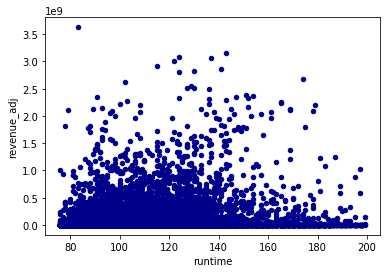

In [14]:
df_inflated_adj.loc[(df_inflated_adj['runtime']<200) & (df_inflated_adj['runtime']>75) & (df_inflated_adj['revenue_adj']<4000000000)][['runtime','revenue_adj']].plot.scatter(x='runtime',
                      y='revenue_adj',
                      c='DarkBlue')

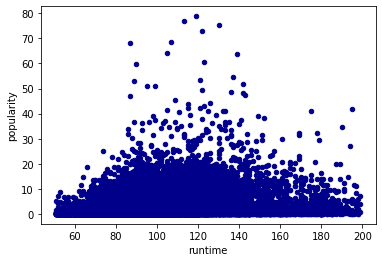

In [110]:
df_inflated_adj.loc[(df_inflated_adj['runtime']<200) &(df_inflated_adj['popularity']<80) & (df_inflated_adj['runtime']>50)] [['runtime','popularity']].plot.scatter(x='runtime',
                      y='popularity',
                      c='DarkBlue')

Collection Analysis

In [14]:
import ast
df_collection=df_inflated_adj[['id','belongs_to_collection']]
df_collection = df_collection[df_collection['belongs_to_collection'].notnull()]
df_collection['belongs_to_collection'] = df_collection['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)


In [15]:
df_coll_test=pd.DataFrame(df_collection.groupby('belongs_to_collection')['id'].nunique().sort_values(ascending=False).reset_index())
df_coll_test.columns = ['collection', 'movie_count']
df_coll_test[df_coll_test['movie_count']>10]

,collection,movie_count
0,The Bowery Boys,29
1,Totò Collection,27
2,James Bond Collection,26
3,Zatôichi: The Blind Swordsman,26
4,The Carry On Collection,25
5,Charlie Chan (Sidney Toler) Collection,21
6,Pokémon Collection,20
7,Godzilla (Showa) Collection,16
8,Charlie Chan (Warner Oland) Collection,15
9,Dragon Ball Z (Movie) Collection,15


In [16]:
df_coll_test.nunique()

collection     1692
movie_count      21
dtype: int64

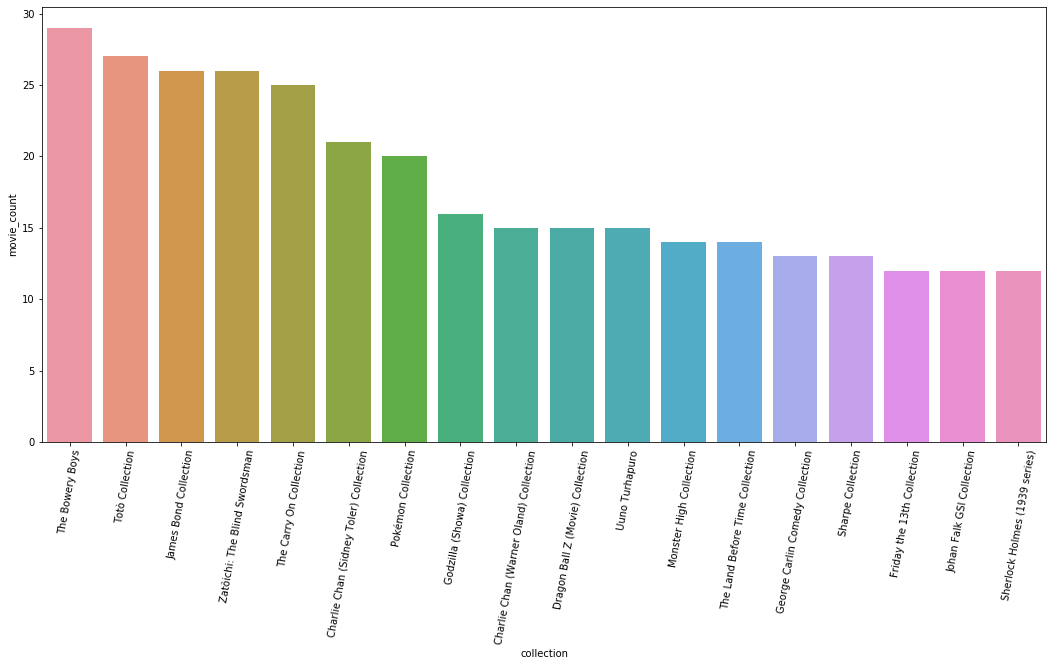

In [17]:
plt.figure(figsize=(18,8))
sns.barplot(x='collection', y='movie_count', data=df_coll_test.head(18))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=80)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


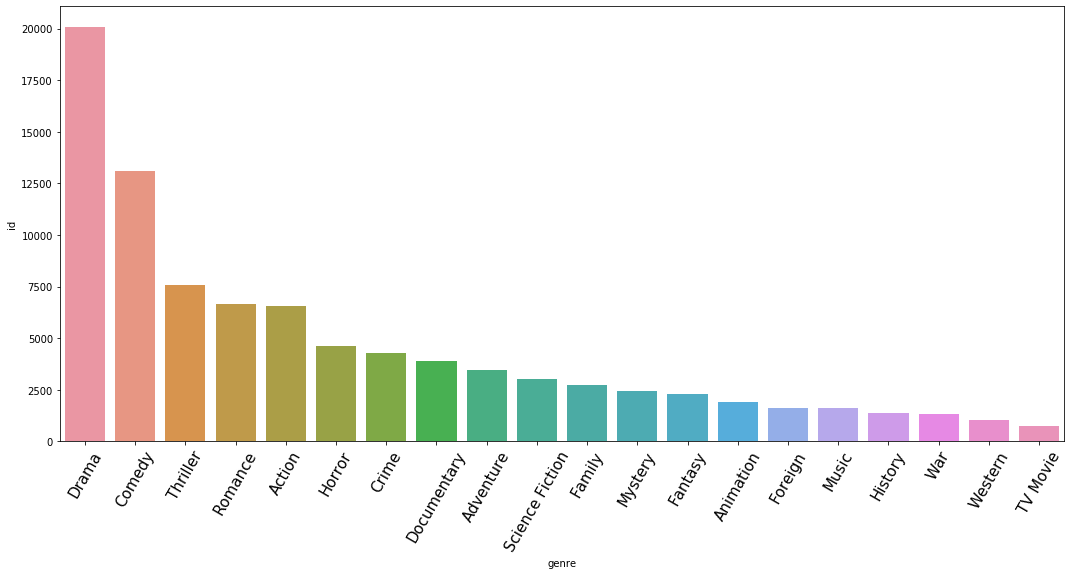

In [18]:
df_genre=df_inflated_adj[['id','genres']]
from ast import literal_eval
df_genre['genres'] = df_genre['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s = df_genre.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
df_genre = df_genre.drop('genres', axis=1).join(s)
df_genre_ct=df_genre.groupby('genre')['id'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='id', data=df_genre_ct)
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=60)
plt.show()

In [19]:
genres = ['Comedy','Action','Drama','Adventure','Thriller','Horror','Family','Science Fiction','Animation','Crime','Fantasy','Mystery','Romance','Documentary','TV Movie','Music','Foreign','War','History','Western']
##Flags for each genre
for genre in genres:
    df_genre[genre] = df_genre['genre'] == genre
##Replace less popular genres wit alikes
df_genre[df_genre['TV Movie']==1]['Drama']=1
df_genre[df_genre['Foreign']==1]['Drama']=1
df_genre[df_genre['Western']==1]['Drama']=1
df_genre[df_genre['War']==1]['History']=1
df_genre[df_genre['Crime']==1]['Action']=1
df_genre[df_genre['Mystery']==1]['Thriller']=1
df_genre_grouped=df_genre.groupby('id')['Comedy','Action','Drama','Adventure','Thriller','Horror','Family','Science Fiction','Animation','Fantasy','Romance','Documentary','Music','History'].max().reset_index()
df_genre_grouped[['Comedy','Action','Drama','Adventure','Thriller','Horror','Family','Science Fiction','Animation','Fantasy','Romance','Documentary','Music','History']] = df_genre_grouped[['Comedy','Action','Drama','Adventure','Thriller','Horror','Family','Science Fiction','Animation','Fantasy','Romance','Documentary','Music','History']].astype(int)
cols = set(df_genre_grouped.columns)
cols.remove('id')
df_genre_grouped['genre_counts']= df_genre_grouped[cols].sum(axis=1)
df_genre_grouped['genre']=""
df_genre_grouped_1=df_genre_grouped[df_genre_grouped['genre_counts']>1]
df_genre_grouped_2=df_genre_grouped[df_genre_grouped['genre_counts']==1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [20]:
def label_genre(df):
    df.loc[df['History']==1,'genre']=df['genre']+( 'History')+'-'
    df.loc[df['Music']==1,'genre']=df['genre']+( 'Music')+'-'
    df.loc[df['Documentary']==1,'genre']=df['genre']+( 'Documentary')+'-'
    df.loc[df['Romance']==1,'genre']=df['genre']+( 'Romance')+'-'
    df.loc[df['Fantasy']==1,'genre']=df['genre']+( 'Fantasy')+'-'
    df.loc[df['Animation']==1,'genre']=df['genre']+( 'Animation')+'-'
    df.loc[df['Science Fiction']==1,'genre']=df['genre']+( 'Science Fiction')+'-'
    df.loc[df['Family']==1,'genre']=df['genre']+( 'Family')+'-'
    df.loc[df['Horror']==1,'genre']=df['genre']+( 'Horror')+'-'
    df.loc[df['Thriller']==1,'genre']=df['genre']+( 'Thriller')+'-'
    df.loc[df['Adventure']==1,'genre']=df['genre']+( 'Adventure')+'-'
    
label_genre(df_genre_grouped_1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [21]:
def label_genre(df):
    df.loc[df['History']==1,'genre']=df['genre']+( 'History')
    df.loc[df['Music']==1,'genre']=df['genre']+( 'Music')
    df.loc[df['Documentary']==1,'genre']=df['genre']+( 'Documentary')
    df.loc[df['Romance']==1,'genre']=df['genre']+( 'Romance')
    df.loc[df['Fantasy']==1,'genre']=df['genre']+( 'Fantasy')
    df.loc[df['Animation']==1,'genre']=df['genre']+( 'Animation')
    df.loc[df['Science Fiction']==1,'genre']=df['genre']+( 'Science Fiction')
    df.loc[df['Family']==1,'genre']=df['genre']+( 'Family')
    df.loc[df['Horror']==1,'genre']=df['genre']+( 'Horror')
    df.loc[df['Thriller']==1,'genre']=df['genre']+( 'Thriller')
    df.loc[df['Adventure']==1,'genre']=df['genre']+( 'Adventure')
    df.loc[df['Drama']==1,'genre']=df['genre']+( 'Drama')
    df.loc[df['Action']==1,'genre']=df['genre']+( 'Action')
    df.loc[df['Comedy']==1,'genre']=df['genre']+( 'Comedy')

label_genre(df_genre_grouped_2)

In [22]:
df_genre_grouped_1['genre']=df_genre_grouped_1['genre'].astype('str')
df_genre_grouped_2['genre']=df_genre_grouped_2['genre'].astype('str')
df_genre_grouped_1['genre_final']=""
##Strip more than 2 genres
def trunc_at(s):
    return "-".join(s.split("-", 2)[:2])

df_genre_grouped_1['genre_final']=df_genre_grouped_1['genre'].apply(trunc_at)
df_genre_grouped_1['genre_final']=df_genre_grouped_1['genre_final'].str.rstrip('-')
df_genre_grouped_2['genre_final']=df_genre_grouped_2['genre']
df_genre_grouped_3=df_genre_grouped_1[df_genre_grouped_1['genre_final']==""]
df_genre_grouped_1=df_genre_grouped_1[df_genre_grouped_1['genre_final']!=""]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [23]:
def label_genre(df):
    df.loc[df['Drama']==1,'genre']=df['genre']+( 'Drama-')
    df.loc[df['Action']==1,'genre']=df['genre']+( 'Action-')
    df.loc[df['Comedy']==1,'genre']=df['genre']+( 'Comedy-')

label_genre(df_genre_grouped_3)

def trunc_at(s):
    return "-".join(s.split("-", 2)[:2])

df_genre_grouped_3['genre_final']=df_genre_grouped_3['genre'].apply(trunc_at)
df_genre_grouped_3['genre_final']=df_genre_grouped_3['genre_final'].str.rstrip('-')

In [24]:
df_genre_final=pd.concat([df_genre_grouped_1,df_genre_grouped_2,df_genre_grouped_3],axis=0)

In [25]:
df_genre_final

,id,Comedy,Action,Drama,Adventure,Thriller,Horror,Family,Science Fiction,Animation,Fantasy,Romance,Documentary,Music,History,genre_counts,genre,genre_final
3,6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,Thriller-,Thriller
4,11,0,1,0,1,0,0,0,1,0,0,0,0,0,0,3,Science Fiction-Adventure-,Science Fiction-Adventure
5,12,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,Animation-Family-,Animation-Family
6,13,1,0,1,0,0,0,0,0,0,0,1,0,0,0,3,Romance-,Romance
9,16,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,Music-,Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44872,437253,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,Drama-Comedy-,Drama-Comedy
44881,438081,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,Drama-Comedy-,Drama-Comedy
44898,439154,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,Drama-Comedy-,Drama-Comedy
44914,440777,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,Drama-Action-,Drama-Action


In [26]:
df_genre_plot= df_genre_final[['id','genre_final']]

In [27]:
df_genre_plot = df_genre_plot.groupby('genre_final')['id'].nunique().sort_values(ascending=False).reset_index()
df_genre_plot.columns= ['genre', 'movie_count']

In [28]:
df_genre_plot.shape

(72, 2)

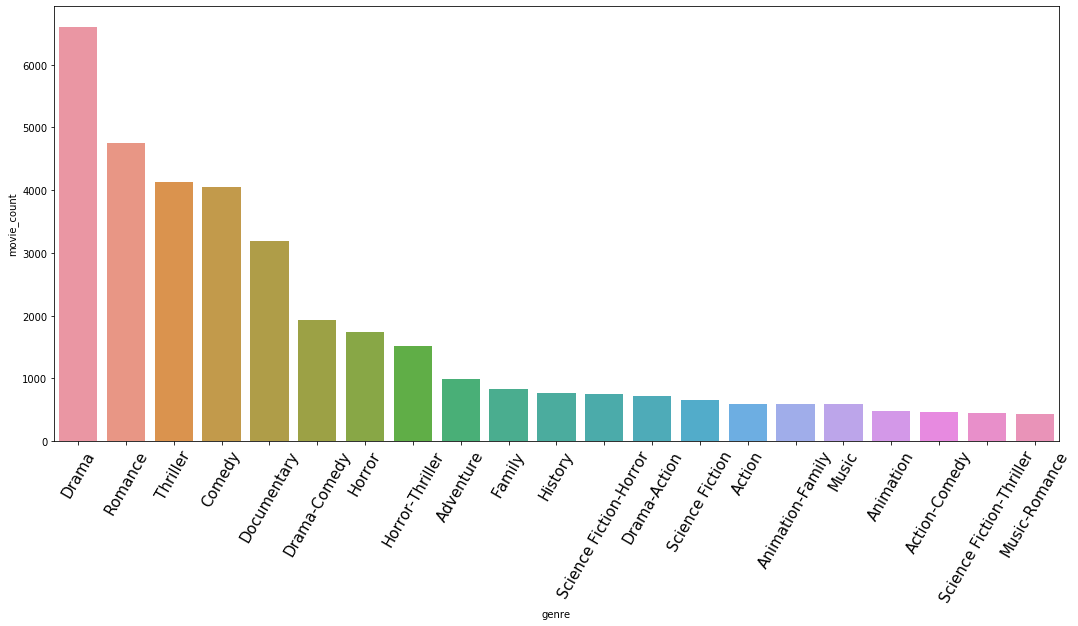

In [29]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movie_count', data=df_genre_plot.head(21))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=60)
plt.show()

Production Companies Analysis

In [30]:
df_prod_comp=df_inflated_adj[['id','production_companies']]
df_prod_comp['production_companies'] = df_prod_comp['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
z = df_prod_comp.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
z.name = 'production_companies'
df_prod_comp = df_prod_comp.drop('production_companies', axis=1).join(z)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
df_prod_comp_test=pd.DataFrame(df_prod_comp.groupby('production_companies')['id'].nunique().sort_values(ascending=False).reset_index())
df_prod_comp_test.columns = ['Production Companies', 'Movie_count']
#df_prod_comp_test.head(100)
df_prod_comp_test[df_prod_comp_test['Movie_count']>50]

,Production Companies,Movie_count
0,Warner Bros.,1248
1,Metro-Goldwyn-Mayer (MGM),1073
2,Paramount Pictures,996
3,Twentieth Century Fox Film Corporation,834
4,Universal Pictures,827
...,...,...
93,Blumhouse Productions,52
94,Pixar Animation Studios,52
95,Lenfilm,52
96,Daiei Studios,51


In [32]:
df_prod_comp_test.nunique()

Production Companies    23425
Movie_count               112
dtype: int64

In [33]:
df_prod_comp

,id,production_companies
0,862,Pixar Animation Studios
1,8844,TriStar Pictures
1,8844,Teitler Film
1,8844,Interscope Communications
2,15602,Warner Bros.
...,...,...
45090,439050,NaN
45091,111109,Sine Olivia
45092,67758,American World Pictures
45093,227506,Yermoliev


In [34]:
df_prod_comp_coun=pd.DataFrame(df_prod_comp.groupby('id')['production_companies'].count().sort_values(ascending=False).reset_index())
df_prod_comp_coun.columns = ['id', 'count of comp']
df_prod_comp_coun


,id,count of comp
0,345775,26
1,8985,26
2,16,26
3,8883,25
4,17609,24
...,...,...
45061,41869,0
45062,41863,0
45063,41850,0
45064,182583,0


In [35]:
df_company=df_inflated_adj[['id','revenue_adj','budget_adj']].merge(df_prod_comp_coun, left_on=['id'], right_on = ['id'], how='inner')
df_company = df_company.merge(df_prod_comp,  left_on=['id'], right_on = ['id'], how='inner')

df_company['count of comp'] = df_company['count of comp'].replace(0, pd.np.nan).dropna(axis=0, how='any').fillna(0).astype(int)
df_company['revenue_split'] = df_company['revenue_adj']/ df_company['count of comp']
df_company['budget_split'] = df_company['budget_adj']/ df_company['count of comp']
df_company.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


,id,revenue_adj,budget_adj,count of comp,production_companies,revenue_split,budget_split
0,862,9.812354e+08,4.880269e+07,1.0,Pixar Animation Studios,9.812354e+08,4.880269e+07
1,8844,6.883870e+08,1.052649e+08,3.0,TriStar Pictures,2.294623e+08,3.508831e+07
2,8844,6.883870e+08,1.052649e+08,3.0,Teitler Film,2.294623e+08,3.508831e+07
3,8844,6.883870e+08,1.052649e+08,3.0,Interscope Communications,2.294623e+08,3.508831e+07
4,15602,0.000000e+00,0.000000e+00,2.0,Warner Bros.,0.000000e+00,0.000000e+00
5,15602,0.000000e+00,0.000000e+00,2.0,Lancaster Gate,0.000000e+00,0.000000e+00
6,31357,2.133607e+08,2.591137e+07,1.0,Twentieth Century Fox Film Corporation,2.133607e+08,2.591137e+07
7,11862,2.035619e+08,0.000000e+00,2.0,Sandollar Productions,1.017810e+08,0.000000e+00
8,11862,2.035619e+08,0.000000e+00,2.0,Touchstone Pictures,1.017810e+08,0.000000e+00
9,949,4.909833e+08,9.716763e+07,3.0,Regency Enterprises,1.636611e+08,3.238921e+07


In [36]:
df_company.count()

id                      81997
revenue_adj             81695
budget_adj              81695
count of comp           70271
production_companies    70271
revenue_split           70097
budget_split            70097
dtype: int64

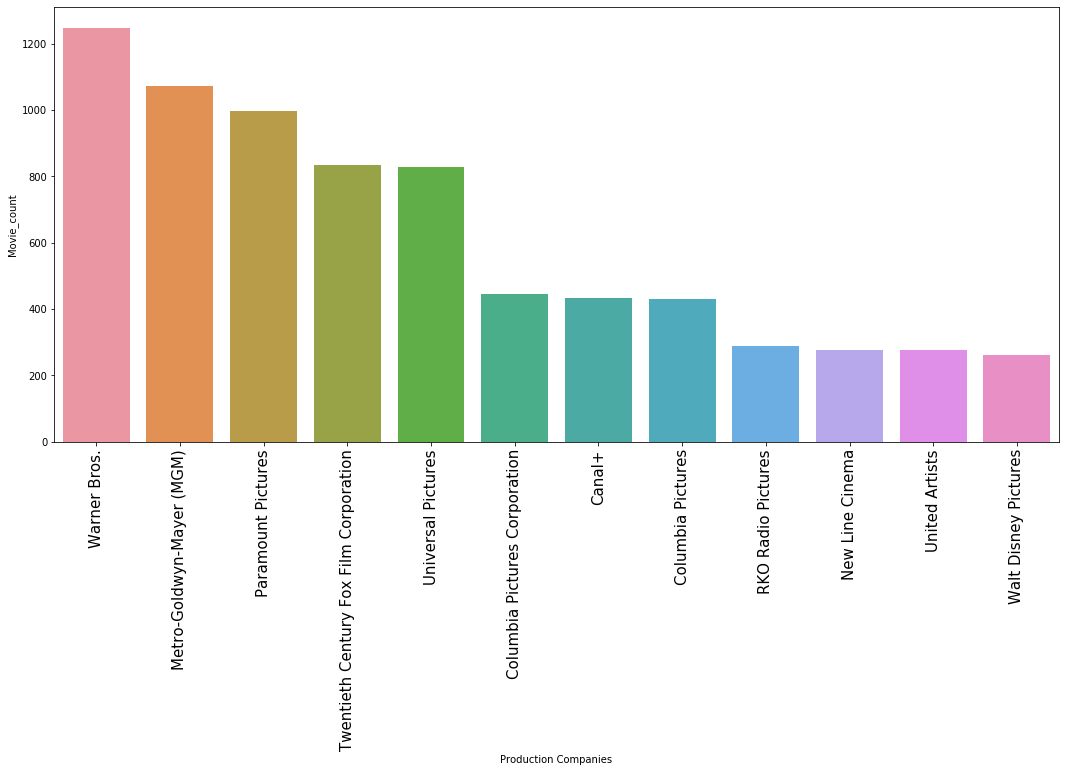

In [37]:
plt.figure(figsize=(18,8))
sns.barplot(x='Production Companies', y='Movie_count', data=df_prod_comp_test.head(12))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=90)
plt.show()

Production Countries

In [38]:
import ast
from ast import literal_eval
df_prod_country=df_inflated_adj[['id','production_countries']]
df_prod_country['production_countries'] = df_prod_country['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
v = df_prod_country.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
v.name = 'production_countries'
df_prod_country = df_prod_country.drop('production_countries', axis=1).join(v)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [39]:
df_prod_country.nunique()

id                      45066
production_countries      160
dtype: int64

In [40]:
df_prod_country_test=pd.DataFrame(df_prod_country.groupby('production_countries')['id'].nunique().sort_values(ascending=False).reset_index())
df_prod_country_test.columns = ['production_countries', 'Movie_count']
#df_prod_country_test.head(60)
df_prod_country_test[df_prod_country_test['Movie_count']>200]

,production_countries,Movie_count
0,United States of America,21019
1,United Kingdom,4076
2,France,3896
3,Germany,2237
4,Italy,2145
5,Canada,1744
6,Japan,1639
7,Spain,956
8,Russia,905
9,India,821


In [41]:
df_prod_country_1=df_prod_country.merge(df_prod_country_test, left_on=['production_countries'], right_on = ['production_countries'], how='inner')
df_prod_country_1

,id,production_countries,Movie_count
0,862,United States of America,21019
1,8844,United States of America,21019
2,15602,United States of America,21019
3,31357,United States of America,21019
4,11862,United States of America,21019
...,...,...,...
49074,132873,Antarctica,1
49075,16403,Gibraltar,1
49076,277690,Brunei Darussalam,1
49077,321530,Honduras,1


In [42]:
df_prod_compo1= df_prod_country_1.groupby('id')['Movie_count'].max().reset_index()
df_prod_compo1

,id,Movie_count
0,2,378
1,3,378
2,5,21019
3,6,21019
4,11,21019
...,...,...
38867,465044,4076
38868,467731,21019
38869,468343,378
38870,468707,378


In [43]:
df_prod_country_final=df_prod_country_test.merge(df_prod_compo1, left_on=['Movie_count'], right_on = ['Movie_count'], how='inner')
df_prod_country_final=df_prod_country_final.groupby(['id','Movie_count'])['production_countries'].max().reset_index()

In [44]:
df_prod_country_final_plot= df_prod_country.groupby('production_countries')['id'].nunique().reset_index().sort_values(ascending=False,by='id')
df_prod_country_final_plot.columns= ['production_country','movie_count']


In [45]:
df_prod_country_final_plot.count()

production_country    160
movie_count           160
dtype: int64

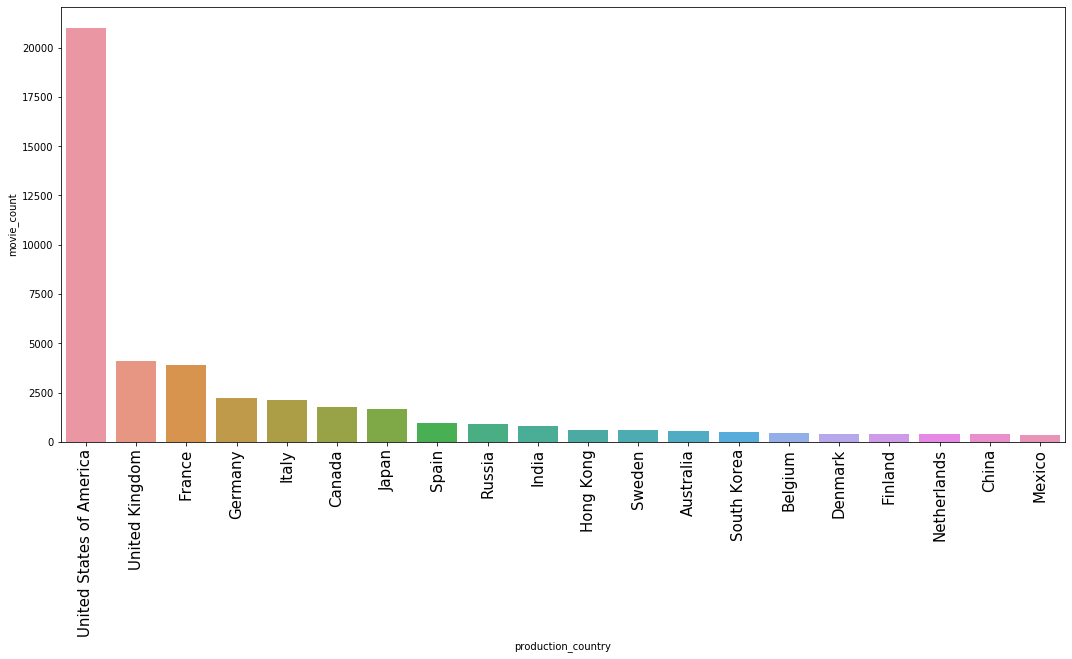

In [46]:
plt.figure(figsize=(18,8))
sns.barplot(x='production_country', y='movie_count', data=df_prod_country_final_plot.head(20))
plt.rcParams["xtick.labelsize"] = 10
plt.xticks(
    rotation=90)
plt.show()

Dubbed Languages Analysis

In [47]:
df_spoken_lang=df_inflated_adj[['id','spoken_languages']]
df_spoken_lang['spoken_languages'] = df_spoken_lang['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
u = df_spoken_lang.apply(lambda x: pd.Series(x['spoken_languages']),axis=1).stack().reset_index(level=1, drop=True)
u.name = 'spoken_languages'
df_spoken_lang = df_spoken_lang.drop('spoken_languages', axis=1).join(u)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
df_spoken_orig_lang=df_inflated_adj[['id','original_language']].merge(df_spoken_lang, left_on=['id'], right_on = ['id'], how='inner')

In [49]:
df_spoken_orig_lang.shape

(56767, 3)

In [50]:
df_spoken_orig_language=pd.DataFrame(df_spoken_lang.groupby('spoken_languages')['id'].nunique().sort_values(ascending=False).reset_index())
df_spoken_orig_language.columns = ['Spoken Languages', 'Movie_count']
df_spoken_orig_language.head(10)


# plt.figure(figsize=(18,8))
# sns.barplot(x='Spoken Languages', y='Movie_count', data=df_spoken_orig_language.head(10))
# plt.rcParams["xtick.labelsize"] = 15
# plt.xticks(
#     rotation=90)
# plt.show()

,Spoken Languages,Movie_count
0,English,28524
1,Français,4164
2,Deutsch,2608
3,Español,2396
4,Italiano,2345
5,日本語,1747
6,Pусский,1553
7,普通话,784
8,हिन्दी,696
9,Português,590


In [60]:
df_spoken_orig_lang=df_spoken_orig_lang[df_spoken_orig_lang['original_language']!=df_spoken_orig_lang['spoken_languages']]

In [61]:
df_spoken_orig_lang.shape

(56767, 3)

In [62]:
#df_spoken_orig_lang['original_language'].map({'en': 'English', 'fr': 'FranÃ§ais', 'it': 'Italiano',
df_spoken_orig_lang['original_language'].replace('en', 'English',inplace=True)
df_spoken_orig_lang['original_language'].replace('fr', 'FranÃ§ais',inplace=True)
df_spoken_orig_lang['original_language'].replace('it', 'Italiano',inplace=True)
df_spoken_orig_lang['original_language'].replace('ja', 'æ—¥æœ¬èªž',inplace=True)
df_spoken_orig_lang['original_language'].replace('de', 'Deutsch',inplace=True)
df_spoken_orig_lang['original_language'].replace('cy', 'Cymraeg',inplace=True)
df_spoken_orig_lang['original_language'].replace('eo', 'Esperanto',inplace=True)
df_spoken_orig_lang['original_language'].replace('es', 'EspaÃ±ol',inplace=True)
df_spoken_orig_lang['original_language'].replace('ar', 'Ø§Ù„Ø¹Ø±Ø¨ÙŠØ©',inplace=True)
df_spoken_orig_lang['original_language'].replace('he', '×¢Ö´×‘Ö°×¨Ö´×™×ª',inplace=True)
df_spoken_orig_lang['original_language'].replace('qu', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('zh', 'æ™®é€šè¯',inplace=True)
df_spoken_orig_lang['original_language'].replace('zu', 'isiZulu',inplace=True)
df_spoken_orig_lang['original_language'].replace('ln', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('lo', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('la', 'Latin',inplace=True)
df_spoken_orig_lang['original_language'].replace('lv', 'LatvieÅ¡u',inplace=True)
df_spoken_orig_lang['original_language'].replace('ru', 'PÑƒÑÑÐºÐ¸Ð¹',inplace=True)
df_spoken_orig_lang['original_language'].replace('lt', 'Lietuvi\x9akai',inplace=True)
df_spoken_orig_lang['original_language'].replace('ru', 'PÑƒÑÑÐºÐ¸Ð¹',inplace=True)
df_spoken_orig_lang['original_language'].replace('ab', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('ka', 'áƒ¥áƒáƒ áƒ—áƒ£áƒšáƒ˜',inplace=True)
df_spoken_orig_lang['original_language'].replace('af', 'Afrikaans',inplace=True)
df_spoken_orig_lang['original_language'].replace('xh', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('am', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('bm', 'Bamanankan',inplace=True)
df_spoken_orig_lang['original_language'].replace('bg', 'Ð±ÑŠÐ»Ð³Ð°Ñ€ÑÐºÐ¸ ÐµÐ·Ð¸Ðº',inplace=True)
df_spoken_orig_lang['original_language'].replace('sr', 'Srpski',inplace=True)
df_spoken_orig_lang['original_language'].replace('da', 'Dansk',inplace=True)
df_spoken_orig_lang['original_language'].replace('ce', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('hi', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('gd', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('yi', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('ro', 'RomÃ¢nÄƒ',inplace=True)
df_spoken_orig_lang['original_language'].replace('gn', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('ko', 'í•œêµ­ì–´/ì¡°ì„ ë§',inplace=True)
df_spoken_orig_lang['original_language'].replace('gu', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('gl', 'Galego',inplace=True)
df_spoken_orig_lang['original_language'].replace('mk', '',inplace=True)
df_spoken_orig_lang['original_language'].replace('hf','Hausa',inplace=True)
df_spoken_orig_lang['original_language'].replace('ig','',inplace=True)
df_spoken_orig_lang['original_language'].replace('sv','svenska',inplace=True)
df_spoken_orig_lang['original_language'].replace('sw','Kiswahili',inplace=True)
df_spoken_orig_lang['original_language'].replace('vi','Tiáº¿ng Viá»‡t',inplace=True)
df_spoken_orig_lang['original_language'].replace('fi','suomi',inplace=True)
df_spoken_orig_lang['original_language'].replace('ff','Fulfulde',inplace=True)
df_spoken_orig_lang['original_language'].replace('ca','CatalÃ ',inplace=True)
df_spoken_orig_lang['original_language'].replace('xx','No Language',inplace=True)
df_spoken_orig_lang['original_language'].replace('he','×¢Ö´×‘Ö°×¨Ö´×™×ª',inplace=True)
df_spoken_orig_lang['original_language'].replace('hy','',inplace=True)
df_spoken_orig_lang['original_language'].replace('nl','Nederlands',inplace=True)
df_spoken_orig_lang['original_language'].replace('pl','PortuguÃªs',inplace=True)
df_spoken_orig_lang['original_language'].replace('lb','',inplace=True)
df_spoken_orig_lang['original_language'].replace('si','',inplace=True)
df_spoken_orig_lang['original_language'].replace('ay','PortuguÃªs',inplace=True)
df_spoken_orig_lang['original_language'].replace('mt','Malti',inplace=True)
df_spoken_orig_lang['original_language'].replace('fy','',inplace=True)
df_spoken_orig_lang['original_language'].replace('tg','',inplace=True)
df_spoken_orig_lang['original_language'].replace('jv','',inplace=True)
df_spoken_orig_lang['original_language'].replace('uz','ozbek',inplace=True)
df_spoken_orig_lang['original_language'].replace('sm','',inplace=True)
df_spoken_orig_lang['original_language'].replace('fa','ÙØ§Ø±Ø³ÛŒ',inplace=True)
df_spoken_orig_lang['original_language'].replace('tl','',inplace=True)
df_spoken_orig_lang['original_language'].replace('cn','å¹¿å·žè¯ / å»£å·žè©±',inplace=True)
df_spoken_orig_lang['original_language'].replace('rw','Kinyarwanda',inplace=True)
df_spoken_orig_lang['original_language'].replace('pt','PortuguÃªs',inplace=True)
df_spoken_orig_lang['original_language'].replace('tr','TÃ¼rkÃ§e',inplace=True)
df_spoken_orig_lang['original_language'].replace('cs','ÄŒeskÃ½',inplace=True)
df_spoken_orig_lang['original_language'].replace('el','ÎµÎ»Î»Î·Î½Î¹ÎºÎ¬',inplace=True)
df_spoken_orig_lang['original_language'].replace('no','Norsk',inplace=True)
df_spoken_orig_lang['original_language'].replace('hu','Magyar',inplace=True)

In [64]:
df_spoken_id = df_spoken_orig_lang[['spoken_languages','id']]

In [65]:
df_spoken_id.columns = ['Dubbed_language','id']
df_spoken_id

,Dubbed_language,id
0,English,862
1,English,8844
2,Français,8844
3,English,15602
4,English,31357
...,...,...
56762,فارسی,439050
56763,,111109
56764,English,67758
56765,NaN,227506


In [67]:
df_spoken_id.head()

,Dubbed_language,id
0,English,862
1,English,8844
2,Français,8844
3,English,15602
4,English,31357


In [107]:
df_spoken_id=df_final[['id','popularity','year','production_companies']].merge(df_spoken_id, left_on=['id'], right_on = ['id'], how='inner')

In [108]:
df_spoken_id.to_csv('spoken.csv')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 144 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 157 missing from current font.
  f

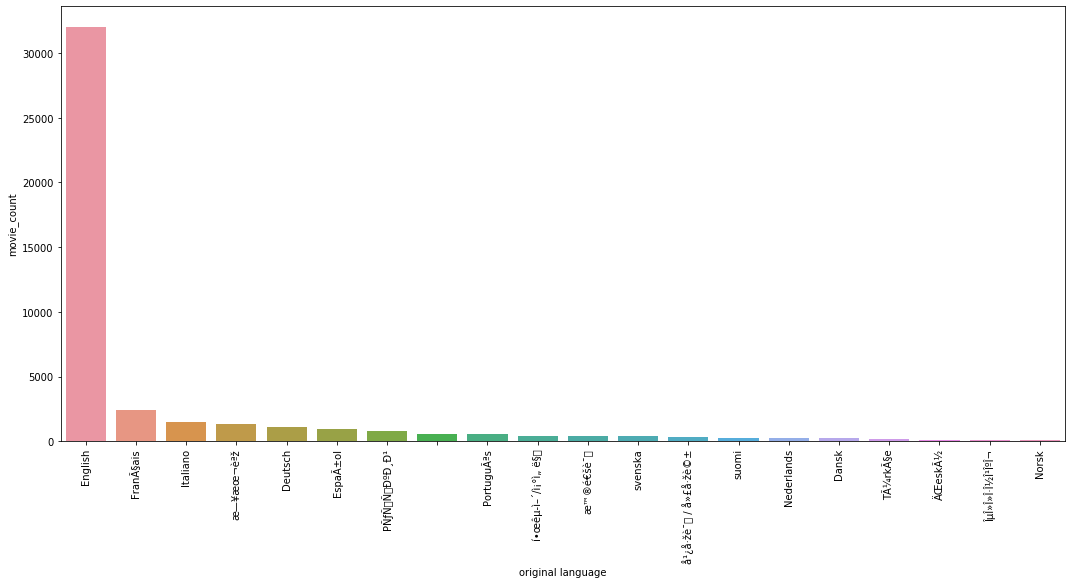

In [69]:
df_orig_lang_count=pd.DataFrame(df_spoken_orig_lang.groupby('original_language')['id'].nunique().sort_values(ascending=False).reset_index())
df_orig_lang_count.columns = ['original language', 'movie_count']
plt.figure(figsize=(18,8))
sns.barplot (x='original language', y='movie_count', data=df_orig_lang_count.head(20))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=90)

plt.show()

In [70]:
language = ['Français','Español','English','日本語','Deutsch','Pусский','Italiano','普通话','हिन्दी','Português']
for spoken_languages in language:
  df_spoken_lang[spoken_languages] = df_spoken_lang['spoken_languages'] == spoken_languages

In [71]:
df_spoken_lang_grouped =df_spoken_lang.groupby('id')['Français','Español','English','日本語','Deutsch','Pусский','Italiano','普通话','हिन्दी','Português'].max().reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [73]:
df_spoken_orig_lang

,id,original_language,spoken_languages
0,862,English,English
1,8844,English,English
2,8844,English,Français
3,15602,English,English
4,31357,English,English
...,...,...,...
56762,439050,ÙØ§Ø±Ø³ÛŒ,فارسی
56763,111109,,
56764,67758,English,English
56765,227506,English,NaN


In [74]:
df_keywords=pd.read_csv('keywords.csv')
from ast import literal_eval
df_keywords['keywords'] = df_keywords['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
p = df_keywords.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
p.name = 'keywords'
df_keywords = df_keywords.drop('keywords', axis=1).join(p)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [75]:
df_keywords.nunique()

id          45432
keywords    19956
dtype: int64

In [76]:
df_keywords_test=pd.DataFrame(df_keywords.groupby('keywords')['id'].nunique().sort_values(ascending=False).reset_index())
df_keywords_test.columns = ['keywords', 'Movie_count']
df_keywords_test.head(30)
#df_keywords_test[df_keywords_test['Movie_count']>100]

,keywords,Movie_count
0,woman director,3039
1,independent film,1914
2,murder,1285
3,based on novel,822
4,musical,726
5,sex,679
6,violence,647
7,nudity,629
8,revenge,618
9,biography,613


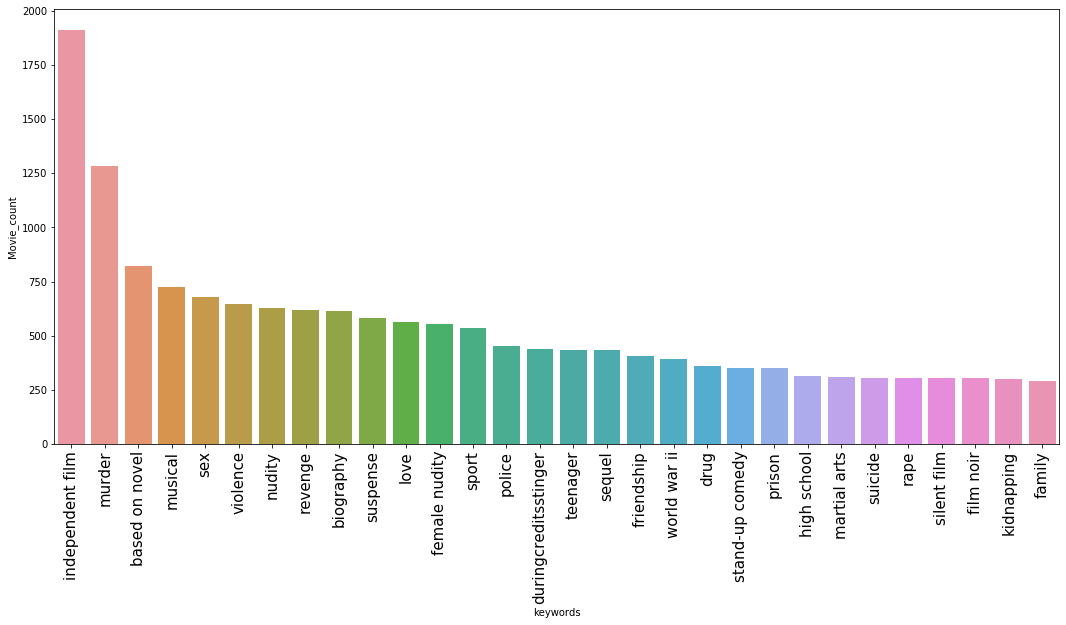

In [77]:
plt.figure(figsize=(18,8))
sns.barplot(x='keywords', y='Movie_count', data=df_keywords_test[df_keywords_test['keywords']!='woman director'].head(30))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=90)
plt.show()

In [78]:
df_keywords_final=df_keywords[['id','keywords']]
keyword = ['woman director','independent film']
for keywords in keyword:
   df_keywords_final[keywords] = df_keywords['keywords'] == keywords

In [79]:
df_keywords_final=df_keywords_final[['id','woman director','independent film']].drop_duplicates().groupby(['id','independent film'])['woman director'].max().reset_index()


In [80]:
df_keywords_final

,id,independent film,woman director
0,2,False,False
1,2,True,False
2,3,False,False
3,3,True,False
4,5,False,True
...,...,...,...
46836,465044,False,False
46837,467731,False,False
46838,468343,False,False
46839,468707,False,False


In [81]:
df_keywords_final=df_keywords_final.groupby(['id','woman director'])['independent film'].max().reset_index()


In [82]:
df_credits = pd.read_csv('credits.csv')
df_credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [83]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [84]:
import ast
df_credits['crew'] = df_credits['crew'].apply(ast.literal_eval)
df_credits['director'] = df_credits['crew'].apply(get_director)

In [85]:
df_credits_test=pd.DataFrame(df_credits.groupby('director')['id'].nunique().sort_values(ascending=False).reset_index())
df_credits_test.columns = ['director', 'Movie_count']
df_credits_test.head(50)

,director,Movie_count
0,John Ford,66
1,Michael Curtiz,65
2,Werner Herzog,54
3,Alfred Hitchcock,53
4,Georges Méliès,51
5,Woody Allen,49
6,Jean-Luc Godard,47
7,Sidney Lumet,46
8,Charlie Chaplin,44
9,Raoul Walsh,43


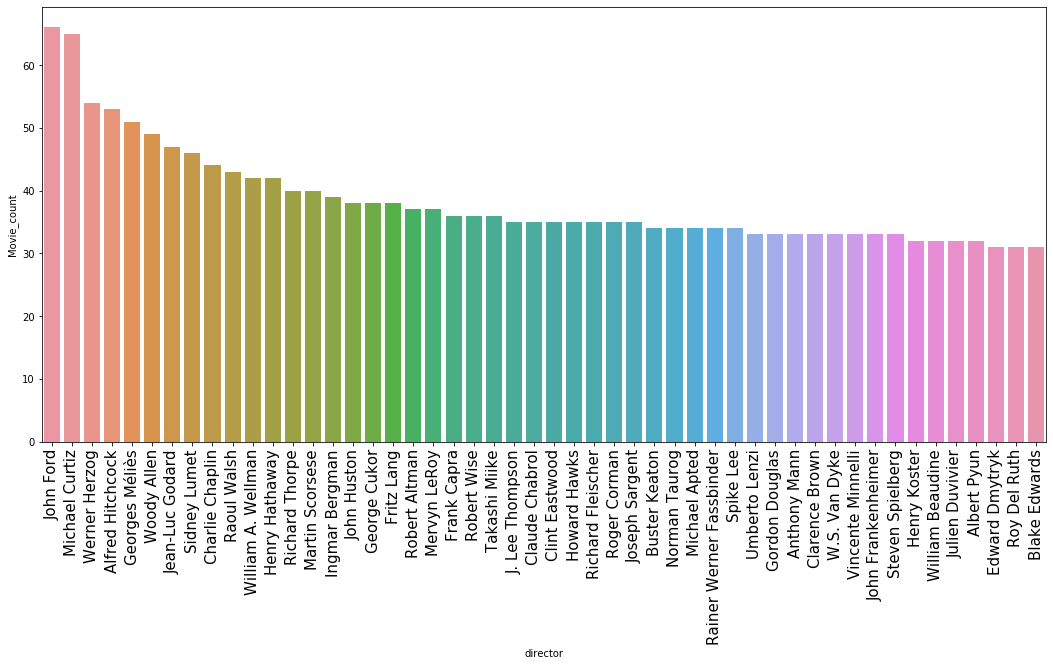

In [86]:
plt.figure(figsize=(18,8))
sns.barplot(x='director', y='Movie_count', data=df_credits_test.head(50))
plt.rcParams["xtick.labelsize"] = 15
plt.xticks(
    rotation=90)
plt.show()

In [87]:
filt= ['id', 'director']
df_director = pd.DataFrame(df_credits, columns= filt )

In [88]:
df_director.nunique()

id          45432
director    17572
dtype: int64

In [89]:
df_director

,id,director
0,862,John Lasseter
1,8844,Joe Johnston
2,15602,Howard Deutch
3,31357,Forest Whitaker
4,11862,Charles Shyer
...,...,...
45471,439050,Hamid Nematollah
45472,111109,Lav Diaz
45473,67758,Mark L. Lester
45474,227506,Yakov Protazanov


In [90]:
df_inflated_adj['original_language'].replace('en', 'English',inplace=True)
df_inflated_adj['original_language'].replace('fr', 'FranÃ§ais',inplace=True)
df_inflated_adj['original_language'].replace('it', 'Italiano',inplace=True)
df_inflated_adj['original_language'].replace('ja', 'æ—¥æœ¬èªž',inplace=True)
df_inflated_adj['original_language'].replace('de', 'Deutsch',inplace=True)
df_inflated_adj['original_language'].replace('cy', 'Cymraeg',inplace=True)
df_inflated_adj['original_language'].replace('eo', 'Esperanto',inplace=True)
df_inflated_adj['original_language'].replace('es', 'EspaÃ±ol',inplace=True)
df_inflated_adj['original_language'].replace('ar', 'Ø§Ù„Ø¹Ø±Ø¨ÙŠØ©',inplace=True)
df_inflated_adj['original_language'].replace('he', '×¢Ö´×‘Ö°×¨Ö´×™×ª',inplace=True)
df_inflated_adj['original_language'].replace('qu', '',inplace=True)
df_inflated_adj['original_language'].replace('zh', 'æ™®é€šè¯',inplace=True)
df_inflated_adj['original_language'].replace('zu', 'isiZulu',inplace=True)
df_inflated_adj['original_language'].replace('ln', '',inplace=True)
df_inflated_adj['original_language'].replace('lo', '',inplace=True)
df_inflated_adj['original_language'].replace('la', 'Latin',inplace=True)
df_inflated_adj['original_language'].replace('lv', 'LatvieÅ¡u',inplace=True)
df_inflated_adj['original_language'].replace('ru', 'PÑƒÑÑÐºÐ¸Ð¹',inplace=True)
df_inflated_adj['original_language'].replace('lt', 'Lietuvi\x9akai',inplace=True)
df_inflated_adj['original_language'].replace('ru', 'PÑƒÑÑÐºÐ¸Ð¹',inplace=True)
df_inflated_adj['original_language'].replace('ab', '',inplace=True)
df_inflated_adj['original_language'].replace('ka', 'áƒ¥áƒáƒ áƒ—áƒ£áƒšáƒ˜',inplace=True)
df_inflated_adj['original_language'].replace('af', 'Afrikaans',inplace=True)
df_inflated_adj['original_language'].replace('xh', '',inplace=True)
df_inflated_adj['original_language'].replace('am', '',inplace=True)
df_inflated_adj['original_language'].replace('bm', 'Bamanankan',inplace=True)
df_inflated_adj['original_language'].replace('bg', 'Ð±ÑŠÐ»Ð³Ð°Ñ€ÑÐºÐ¸ ÐµÐ·Ð¸Ðº',inplace=True)
df_inflated_adj['original_language'].replace('sr', 'Srpski',inplace=True)
df_inflated_adj['original_language'].replace('da', 'Dansk',inplace=True)
df_inflated_adj['original_language'].replace('ce', '',inplace=True)
df_inflated_adj['original_language'].replace('hi', '',inplace=True)
df_inflated_adj['original_language'].replace('gd', '',inplace=True)
df_inflated_adj['original_language'].replace('yi', '',inplace=True)
df_inflated_adj['original_language'].replace('ro', 'RomÃ¢nÄƒ',inplace=True)
df_inflated_adj['original_language'].replace('gn', '',inplace=True)
df_inflated_adj['original_language'].replace('ko', 'í•œêµ­ì–´/ì¡°ì„ ë§',inplace=True)
df_inflated_adj['original_language'].replace('gu', '',inplace=True)
df_inflated_adj['original_language'].replace('gl', 'Galego',inplace=True)
df_inflated_adj['original_language'].replace('mk', '',inplace=True)
df_inflated_adj['original_language'].replace('hf','Hausa',inplace=True)
df_inflated_adj['original_language'].replace('ig','',inplace=True)
df_inflated_adj['original_language'].replace('sv','svenska',inplace=True)
df_inflated_adj['original_language'].replace('sw','Kiswahili',inplace=True)
df_inflated_adj['original_language'].replace('vi','Tiáº¿ng Viá»‡t',inplace=True)
df_inflated_adj['original_language'].replace('fi','suomi',inplace=True)
df_inflated_adj['original_language'].replace('ff','Fulfulde',inplace=True)
df_inflated_adj['original_language'].replace('ca','CatalÃ ',inplace=True)
df_inflated_adj['original_language'].replace('xx','No Language',inplace=True)
df_inflated_adj['original_language'].replace('he','×¢Ö´×‘Ö°×¨Ö´×™×ª',inplace=True)
df_inflated_adj['original_language'].replace('hy','',inplace=True)
df_inflated_adj['original_language'].replace('nl','Nederlands',inplace=True)
df_inflated_adj['original_language'].replace('pl','PortuguÃªs',inplace=True)
df_inflated_adj['original_language'].replace('lb','',inplace=True)
df_inflated_adj['original_language'].replace('si','',inplace=True)
df_inflated_adj['original_language'].replace('ay','PortuguÃªs',inplace=True)
df_inflated_adj['original_language'].replace('mt','Malti',inplace=True)
df_inflated_adj['original_language'].replace('fy','',inplace=True)
df_inflated_adj['original_language'].replace('tg','',inplace=True)
df_inflated_adj['original_language'].replace('jv','',inplace=True)
df_inflated_adj['original_language'].replace('uz','ozbek',inplace=True)
df_inflated_adj['original_language'].replace('sm','',inplace=True)
df_inflated_adj['original_language'].replace('fa','ÙØ§Ø±Ø³ÛŒ',inplace=True)
df_inflated_adj['original_language'].replace('tl','',inplace=True)
df_inflated_adj['original_language'].replace('cn','å¹¿å·žè¯ / å»£å·žè©±',inplace=True)
df_inflated_adj['original_language'].replace('rw','Kinyarwanda',inplace=True)

In [91]:
final = ['adult','id','year','month','title','vote_average','vote_count','revenue_adj','budget_adj','original_language','runtime','popularity']
df_final= pd.DataFrame(df_inflated_adj, columns=final)
df_final=df_final.merge(df_director, left_on=['id'], right_on = ['id'], how='left')
df_final=df_company[['id','production_companies','revenue_split','budget_split']].merge(df_final, left_on=['id'], right_on = ['id'], how='inner')
df_final=df_keywords_final.merge(df_final,left_on=['id'], right_on = ['id'], how='right')
df_final=df_prod_country_final[['id','production_countries']].merge(df_final,left_on=['id'], right_on = ['id'], how='right')
df_final=df_final.merge(df_genre_final[['id','genre_final']],left_on=['id'], right_on = ['id'], how='left')

In [92]:
df_final.count()

id                      83542
production_countries    77086
woman director          83541
independent film        83541
production_companies    71666
revenue_split           71492
budget_split            71492
adult                   83542
year                    83542
month                   83542
title                   83542
vote_average            83542
vote_count              83542
revenue_adj             83240
budget_adj              83240
original_language       83524
runtime                 83219
popularity              83542
director                82613
genre_final             80044
dtype: int64

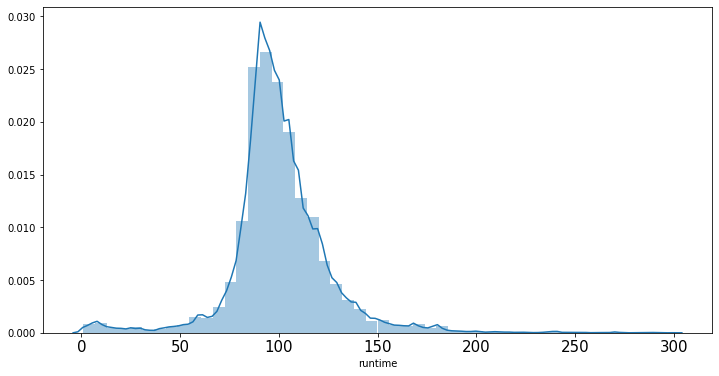

In [93]:
plt.figure(figsize=(12,6))
sns.distplot(df_final[(df_final['runtime'] < 300) & (df_final['runtime'] > 0)]['runtime'])

In [94]:
bins = [0,50,75,100,125,150, np.inf]
names = ['below_50', '50-75', '75-100','100-125','125-150','above_150']

df_final['classification_runtime'] = pd.cut(df_final['runtime'], bins, labels=names)

print(df_final['classification_runtime'])

0          50-75
1          50-75
2         75-100
3         75-100
4         75-100
          ...   
83537    100-125
83538        NaN
83539      50-75
83540      50-75
83541        NaN
Name: classification_runtime, Length: 83542, dtype: category
Categories (6, object): [below_50 < 50-75 < 75-100 < 100-125 < 125-150 < above_150]


In [95]:
df_final['genre_final'].value_counts()

Drama                      13064
Romance                     8993
Thriller                    8924
Comedy                      6698
Documentary                 4299
                           ...  
Family-Horror                 17
History-Animation             16
Documentary-Fantasy           10
Music-Adventure                7
History-Science Fiction        2
Name: genre_final, Length: 72, dtype: int64

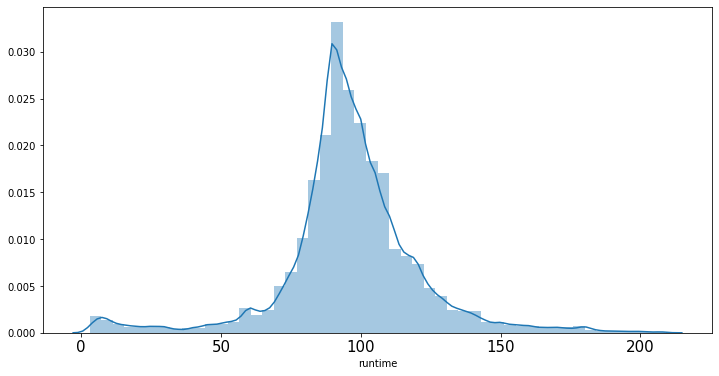

In [96]:
df_inflated_adj['norm_runtime'] = (df_inflated_adj['runtime']-df_inflated_adj['runtime'].mean())/df_inflated_adj['runtime'].std()

plt.figure(figsize=(12,6))
sns.distplot(df_inflated_adj[(df_inflated_adj['norm_runtime'] < 3) & (df_inflated_adj['norm_runtime'] > -2.4)]['runtime'])


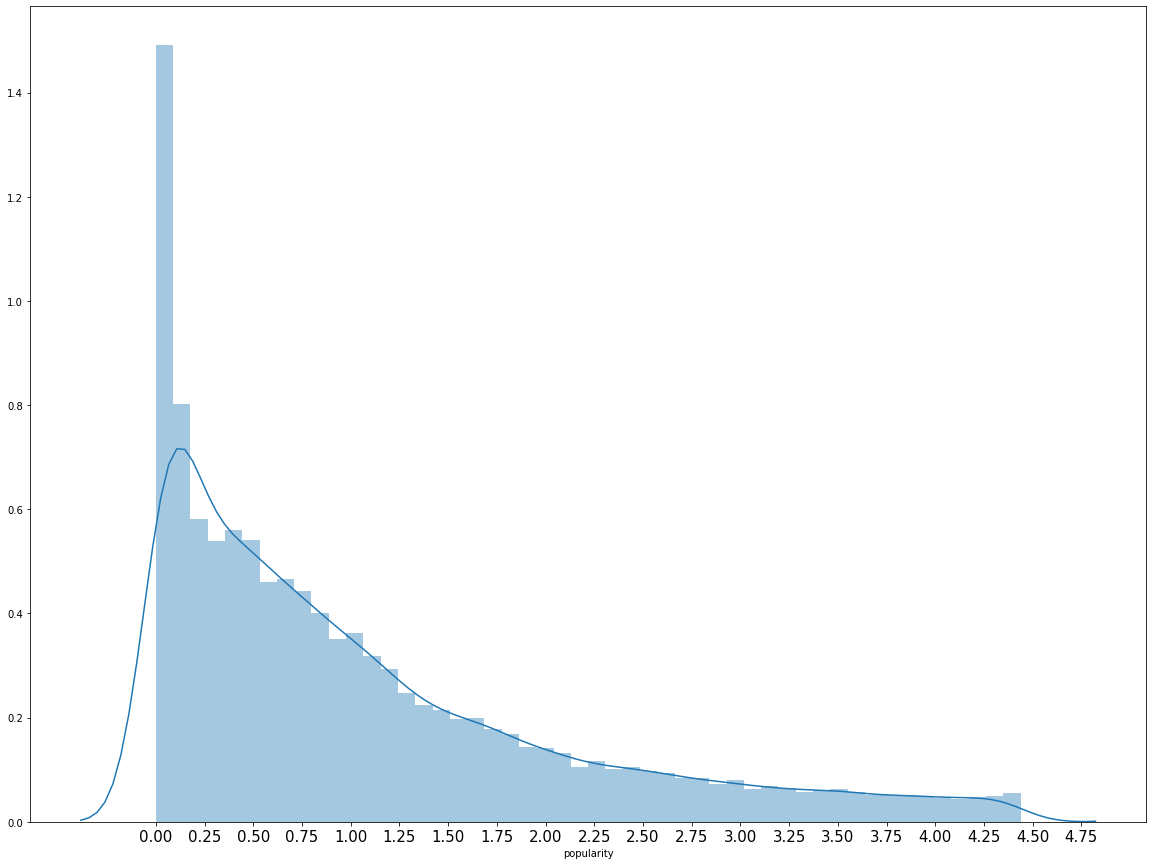

In [97]:
df_inflated_adj['popularity']=df_inflated_adj['popularity'].astype('float')
df_inflated_adj['norm_pop'] = (df_inflated_adj['popularity']-df_inflated_adj['popularity'].mean())/df_inflated_adj['popularity'].std()
plt.figure(figsize=(20,15))
sns.distplot(df_inflated_adj[(df_inflated_adj['norm_pop'] < 0.25) & (df_inflated_adj['norm_pop'] > -3)]['popularity'])
plt.xticks(np.arange(0, 5, step=0.25))
plt.rcParams["xtick.labelsize"] = 10

In [98]:
df_inflated_adj_filtered=df_inflated_adj[df_inflated_adj['revenue_adj']!=0]
df_inflated_adj_filtered['norm_revenue_adj'] = (df_inflated_adj_filtered['revenue_adj']-df_inflated_adj_filtered['revenue_adj'].mean())/df_inflated_adj_filtered['revenue_adj'].std()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
df_inflated_adj_filtered['log_revenue_adj']=np.log10(df_inflated_adj_filtered['revenue_adj'])
df_inflated_adj_filtered['log_budget_adj']=np.log10(df_inflated_adj_filtered['budget_adj'])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
df_inflated_adj_filtered['revenue_adj'].describe()

count    7.396000e+03
mean     1.756623e+08
std      3.689133e+08
min      2.033180e+00
25%      6.724369e+06
50%      4.800378e+07
75%      1.782836e+08
max      8.082579e+09
Name: revenue_adj, dtype: float64

In [106]:
df_inflated_adj_filtered=df_inflated_adj_filtered.dropna(subset=['norm_revenue_adj'])
df_inflated_adj_filtered=df_inflated_adj_filtered.dropna(subset=['norm_budget_adj'])
df_inflated_adj_filtered=df_inflated_adj_filtered.dropna(subset=['log_budget_adj'])


([<matplotlib.axis.XTick at 0x15cce150>,
 <a list of 10 Text xticklabel objects>)

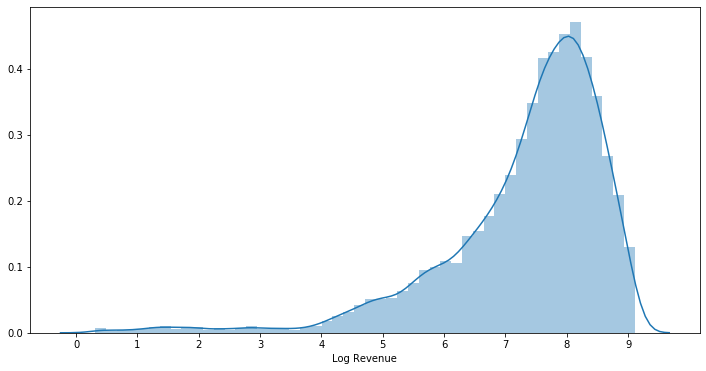

In [102]:
plt.figure(figsize=(12,6))
sns.distplot(df_inflated_adj_filtered[(df_inflated_adj_filtered['norm_revenue_adj'] < 3) & (df_inflated_adj_filtered['norm_revenue_adj'] >-3 )]['log_revenue_adj'])
plt.xlabel("Log Revenue")
plt.xticks(np.arange(0, 10, step=1))

([<matplotlib.axis.XTick at 0x1592f750>,
 <a list of 8 Text xticklabel objects>)

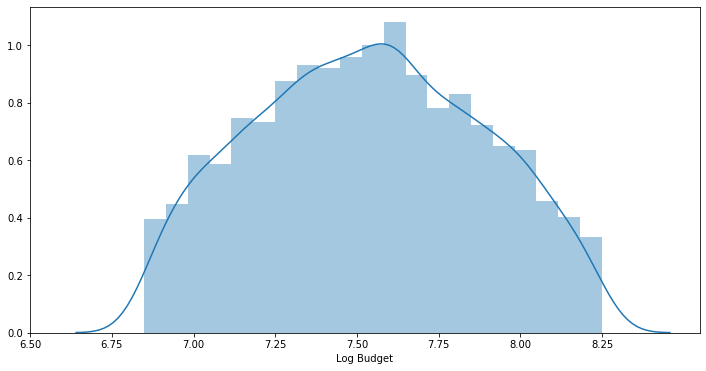

In [103]:
df_inflated_adj_filtered['norm_budget_adj'] = (df_inflated_adj_filtered['budget_adj']-df_inflated_adj_filtered['budget_adj'].mean())/df_inflated_adj_filtered['budget_adj'].std()
plt.figure(figsize=(12,6))
sns.distplot(df_inflated_adj_filtered[(df_inflated_adj_filtered['norm_budget_adj'] < 3) & (df_inflated_adj_filtered['norm_budget_adj'] >-.5 )]['log_budget_adj'])
plt.xlabel("Log Budget")
plt.xticks(np.arange(6.5, 8.5, step=.25))

In [104]:
df_final

,id,production_countries,woman director,independent film,production_companies,revenue_split,budget_split,adult,year,month,...,vote_average,vote_count,revenue_adj,budget_adj,original_language,runtime,popularity,director,genre_final,classification_runtime
0,2,Finland,False,True,Villealfa Filmproduction Oy,0.000000e+00,0.000,False,1988,Oct,...,7.1,44.0,0.000000e+00,0.000,suomi,69.0,3.86049,Aki Kaurismäki,Drama,50-75
1,2,Finland,False,True,Finnish Film Foundation,0.000000e+00,0.000,False,1988,Oct,...,7.1,44.0,0.000000e+00,0.000,suomi,69.0,3.86049,Aki Kaurismäki,Drama,50-75
2,3,Finland,False,True,Villealfa Filmproduction Oy,0.000000e+00,0.000,False,1986,Oct,...,7.1,35.0,0.000000e+00,0.000,suomi,76.0,2.29211,Aki Kaurismäki,Drama-Comedy,75-100
3,5,United States of America,True,False,Miramax Films,5.631840e+06,3238921.054,False,1995,Dec,...,6.5,539.0,1.126368e+07,6477842.108,English,98.0,9.02659,Allison Anders,Comedy,75-100
4,5,United States of America,True,False,A Band Apart,5.631840e+06,3238921.054,False,1995,Dec,...,6.5,539.0,1.126368e+07,6477842.108,English,98.0,9.02659,Allison Anders,Comedy,75-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83537,456956,NaN,False,False,NaN,NaN,NaN,False,NaT,nan,...,10.0,1.0,NaN,NaN,English,110.0,0.000308,Steven Lewis Simpson,Drama,100-125
83538,458335,NaN,False,False,Ananã Produções,0.000000e+00,0.000,False,2017,Jul,...,0.0,0.0,0.000000e+00,0.000,pt,NaN,0.270556,300ml,Drama,NaN
83539,458618,NaN,False,False,NaN,NaN,NaN,False,2017,May,...,2.0,1.0,0.000000e+00,0.000,English,60.0,0.465977,NaN,Documentary,50-75
83540,462026,NaN,False,False,NaN,NaN,NaN,False,2017,Jun,...,0.0,0.0,0.000000e+00,0.000,English,60.0,0.183256,Andrew Kötting,Documentary,50-75


In [105]:
df_final.to_csv('final.csv')